# MLP with GA hyperparameter tuning
---

In [1]:
from typing import List, Dict, Tuple, Callable
import numpy as np
import random

from deap import base, creator, tools, algorithms

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

import multiprocessing
from multiprocessing.pool import ThreadPool

import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from config import config

## Basic Config
---

In [2]:
torch.manual_seed(config.SEED)

# Load Data
---

In [3]:
# Define transformations to apply to the images
# Convert to pytorch tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
trainset = torchvision.datasets.MNIST(
    root="../data",
    train=True,
    transform=transform,
    download=True
)
len(trainset)

60000

In [5]:
testset = torchvision.datasets.MNIST(
    root="../data",
    train=False,
    transform=transform,
    download=True    
)
len(testset)

10000

In [6]:
trainset.data.shape, testset.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
trainset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [8]:
def build_dataloaders(trainset, testset, batch_size: int, seed: int) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_size = int(0.8 * len(trainset))
    val_size = len(trainset) - train_size
    train_subset, val_subset = random_split(trainset, [train_size, val_size], generator=torch.Generator().manual_seed(seed))
    
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2, generator=torch.Generator().manual_seed(seed))
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=2, generator=torch.Generator().manual_seed(seed))
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, generator=torch.Generator().manual_seed(seed))

    return train_loader, val_loader, test_loader

## Model
---

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)

        self.bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

        # Fully coonnected layers
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.bn(self.conv2(x)))
        x = self.pool(x)
        x = self.dropout(x)
        
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [11]:
model = CNN().to(config.DEVICE)

In [12]:
def calculate_metrics(logits: torch.Tensor, labels: torch.Tensor) -> dict:
    predicted = torch.argmax(logits, dim=1).cpu()
    accuracy = (predicted.eq(labels).sum().item()) / labels.shape[0]
    return {"accuracy": accuracy}

In [13]:
@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, criterion) -> Tuple[float, float]:
    """
    Evaluate the model on the given DataLoader. Returns the average loss and accuracy.
    """
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(config.DEVICE), y.to(config.DEVICE)
        logits = model(x)           # Forward pass
        loss = criterion(logits, y) # Compute loss
        metrics = calculate_metrics(logits, y.cpu())

        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_acc += metrics["accuracy"] * batch_size
        n += batch_size
    return total_loss / n, total_acc / n

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [18]:
train_loader, val_loader, test_loader = build_dataloaders(trainset, testset, 16, config.SEED)

# Training loop
best_val_acc = 0.0
patience = 10
patience_counter = 0

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(config.EPOCHS):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for x, y in train_loader:
        x, y = x.to(config.DEVICE), y.to(config.DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        predicted = torch.argmax(logits, dim=1).cpu()
        total_train += y.size(0)
        correct_train += (predicted == y.cpu()).sum().item()
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/{config.EPOCHS} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print(f"\nBest validation accuracy: {best_val_acc:.4f}")

Epoch 1/30 - Val Loss: 0.0710, Val Acc: 0.9784
Epoch 2/30 - Val Loss: 0.0651, Val Acc: 0.9816
Epoch 3/30 - Val Loss: 0.0556, Val Acc: 0.9834
Epoch 4/30 - Val Loss: 0.0393, Val Acc: 0.9895
Epoch 5/30 - Val Loss: 0.0398, Val Acc: 0.9887
Epoch 6/30 - Val Loss: 0.0378, Val Acc: 0.9896
Epoch 7/30 - Val Loss: 0.0355, Val Acc: 0.9902
Epoch 8/30 - Val Loss: 0.0357, Val Acc: 0.9908
Epoch 9/30 - Val Loss: 0.0318, Val Acc: 0.9919
Epoch 10/30 - Val Loss: 0.0337, Val Acc: 0.9912
Epoch 11/30 - Val Loss: 0.0311, Val Acc: 0.9911
Epoch 12/30 - Val Loss: 0.0367, Val Acc: 0.9904
Epoch 13/30 - Val Loss: 0.0329, Val Acc: 0.9922
Epoch 14/30 - Val Loss: 0.0329, Val Acc: 0.9915
Epoch 15/30 - Val Loss: 0.0342, Val Acc: 0.9904
Epoch 16/30 - Val Loss: 0.0326, Val Acc: 0.9909
Epoch 17/30 - Val Loss: 0.0367, Val Acc: 0.9902
Epoch 18/30 - Val Loss: 0.0385, Val Acc: 0.9898
Epoch 19/30 - Val Loss: 0.0328, Val Acc: 0.9916
Epoch 20/30 - Val Loss: 0.0324, Val Acc: 0.9916
Epoch 21/30 - Val Loss: 0.0311, Val Acc: 0.9914
E

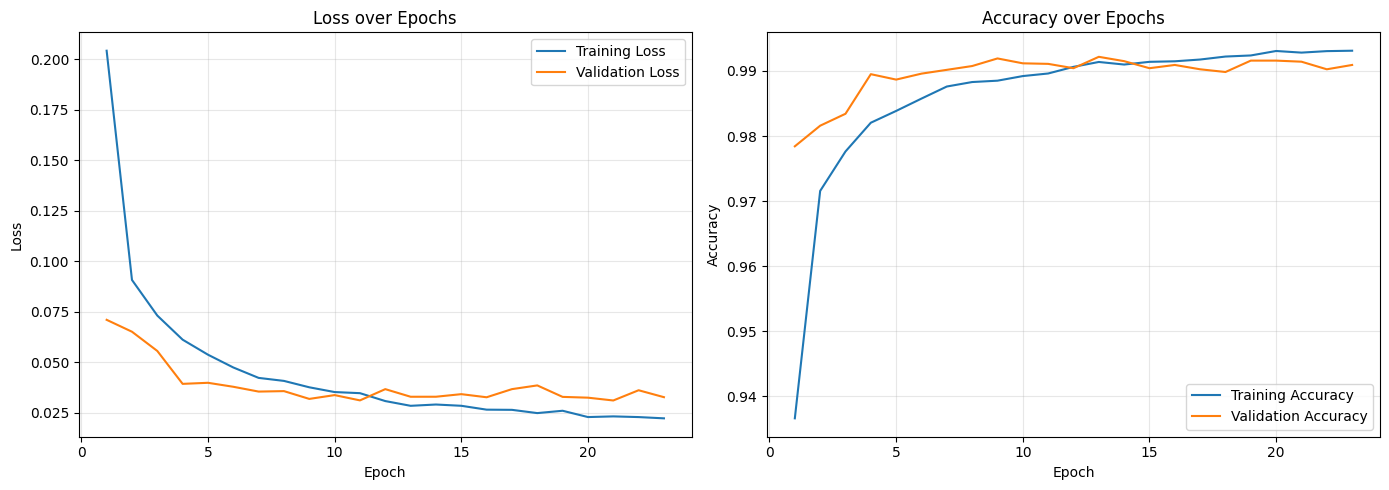

In [19]:
# Plot training and validation metrics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
axes[0].plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
axes[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 0.0297, Test Accuracy: 0.9921


In [15]:
dataiter = iter(test_loader)

NameError: name 'test_loader' is not defined

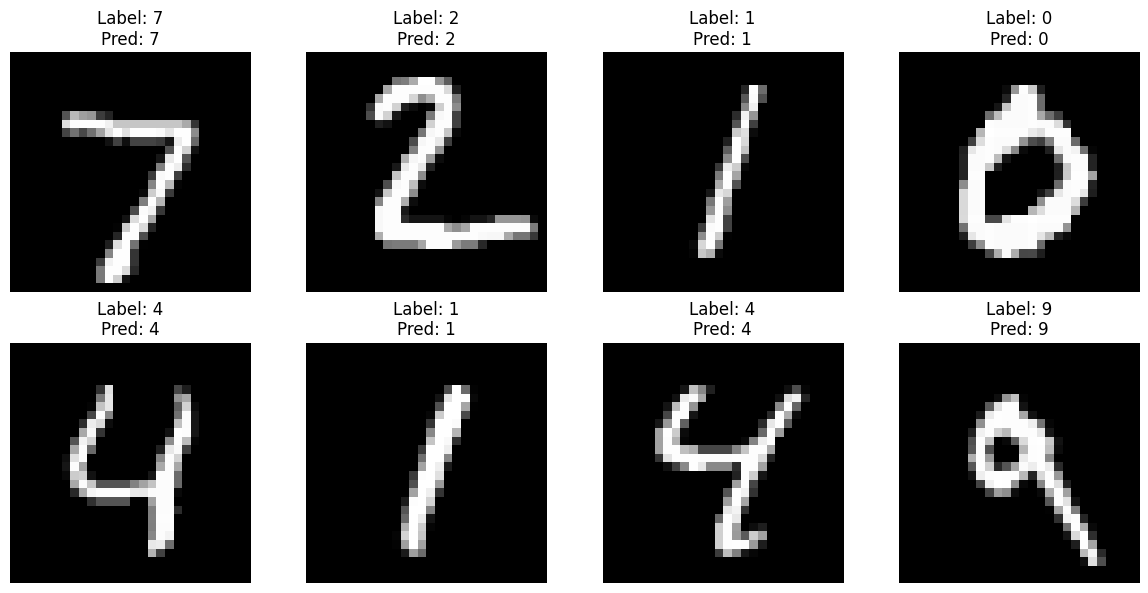

In [22]:
images, labels = next(dataiter)

with torch.no_grad():
    model.eval()
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

def imshow(img: torch.Tensor, title: str = None):
    img = img / 2 + 0.5  # Remove normalization
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    if title is not None:
        plt.title(title)
    plt.axis('off')

num_images = 8
rows = 2
cols = 4
plt.figure(figsize=(12, 6))
for i in range(num_images):
    plt.subplot(rows, cols, i + 1)
    label = labels[i].item()
    pred = preds[i].item()
    title = f"Label: {label}\nPred: {pred}"
    imshow(images[i], title=title)
plt.tight_layout()
plt.show()


## Genetic Algorithm Hyperparameter Optimization (DEAP)
---

In [14]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

In [15]:
toolbox = base.Toolbox()

# Attribute generator
toolbox.register("attr_batch_size", random.choice, [16, 32, 64, 128, 256, 512, 1024])
toolbox.register("attr_optimizer", random.choice, [optim.SGD, optim.Adam, optim.RMSprop])
toolbox.register("attr_lr", random.choice, [0.001, 0.01, 0.005, 0.05, 0.003, 0.03])
toolbox.register("attr_weight_decay", random.choice, [0.0, 1e-5, 1e-4, 1e-3])
toolbox.register("attr_momentum", random.choice, [0.0, 0.3, 0.5, 0.7, 0.9, 0.99])

In [16]:
def create_individual() -> Dict:
    optimizer = toolbox.attr_optimizer()
    if optimizer == optim.Adam:
        individual = {
            "model": CNN(),
            "batch_size": toolbox.attr_batch_size(),
            "optimizer": optimizer,
            "lr": toolbox.attr_lr(),
            "weight_decay": toolbox.attr_weight_decay()
        }
    if optimizer == optim.SGD or optimizer == optim.RMSprop:
        individual = {
            "model": CNN(),
            "batch_size": toolbox.attr_batch_size(),
            "optimizer": optimizer,
            "lr": toolbox.attr_lr(),
            "weight_decay": toolbox.attr_weight_decay(),
            "momentum": toolbox.attr_momentum()
        }
    return individual

In [17]:
individual = create_individual()
individual

{'model': CNN(
   (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout): Dropout(p=0.2, inplace=False)
   (fc1): Linear(in_features=784, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=10, bias=True)
 ),
 'batch_size': 16,
 'optimizer': torch.optim.rmsprop.RMSprop,
 'lr': 0.03,
 'weight_decay': 0.0,
 'momentum': 0.99}

In [18]:
# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [19]:
def eval_mlp(individual: creator.Individual) -> Tuple[float]:
    model: nn.Module = individual["model"]
    batch_size: int = individual["batch_size"]
    optimizer: Callable = individual["optimizer"]
    lr: float = individual["lr"]
    weight_decay: float = individual["weight_decay"]
    momentum: float = individual.get("momentum", None)

    # Instantiate model
    model.to(config.DEVICE)
    criterion = nn.CrossEntropyLoss()

    if optimizer in (optim.RMSprop, optim.SGD):
        local_optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
    if optimizer == optim.Adam:
        local_optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader, val_loader, _ = build_dataloaders(trainset, testset, batch_size, config.SEED)

    # Training loop
    best_val_acc = 0.0
    patience = 5
    patience_counter = 0
    for epoch in range(config.EPOCHS):
        model.train()
        for x, y in train_loader:
            x, y = x.to(config.DEVICE), y.to(config.DEVICE)
            logits = model(x)
            loss = criterion(logits, y)
            local_optimizer.zero_grad()
            loss.backward()
            local_optimizer.step()

        val_loss, val_acc = evaluate(model, val_loader, criterion)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return (best_val_acc,)

In [20]:
def mutate(individual: creator.Individual, indpb: float) -> Tuple[creator.Individual]:
    if random.uniform(0.0, 1.0) < indpb:
        individual["batch_size"] = toolbox.attr_batch_size()
    if random.uniform(0.0, 1.0) < indpb:
        individual["optimizer"] = toolbox.attr_optimizer()
    if random.uniform(0.0, 1.0) < indpb:
        individual["lr"] = toolbox.attr_lr()
    if random.uniform(0.0, 1.0) < indpb:
        individual["weight_decay"] = toolbox.attr_weight_decay()
    if individual["optimizer"] in (optim.SGD, optim.RMSprop):
        if random.uniform(0.0, 1.0) < indpb:
            individual["momentum"] = toolbox.attr_momentum()

    return (individual,)

In [28]:
def crossover(ind1: creator.Individual, ind2: creator.Individual) -> Tuple[creator.Individual]:
    attributes = [key for key in ind1.keys() if key != "model"]
    attribute = random.choice(attributes)

    if attribute == "momentum":
        if ind1["optimizer"] in (optim.SGD, optim.RMSprop) and ind2["optimizer"] in (optim.SGD, optim.RMSprop):
            ind1[attribute], ind2[attribute] = ind2[attribute], ind1[attribute]
        else:
            attribute = random.choice([attr for attr in attributes if attr != "momentum"])
            ind1[attribute], ind2[attribute] = ind2[attribute], ind1[attribute]
    else:
        ind1[attribute], ind2[attribute] = ind2[attribute], ind1[attribute]

    return ind1, ind2

In [29]:
def select(population: List[creator.Individual], k: int, tournsize: int) -> List[creator.Individual]:
    selected = []
    for _ in range(k):
        aspirants = random.sample(population, tournsize)
        best = max(aspirants, key=lambda ind: ind.fitness.values)
        selected.append(best)
    return selected

In [30]:
# Operators
toolbox.register("evaluate", eval_mlp)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate, indpb=config.MUTATION_PROB)
toolbox.register("select", select, tournsize=3)

In [31]:
def GA() -> Tuple[List[creator.Individual], tools.Logbook]:
    pool = ThreadPool(multiprocessing.cpu_count())
    toolbox.register("map", pool.map)
    
    population = toolbox.population(n=config.POPULATION_SIZE)
    hof = tools.HallOfFame(1)

    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    population, logbook = algorithms.eaSimple(
        population,
        toolbox,
        cxpb=config.CROSSOVER_PROB,
        mutpb=config.MUTATION_PROB,
        ngen=config.NUMBER_OF_GENERATIONS,
        stats=stats,
        halloffame=hof,
        verbose=True,
    )

    pool.close()
    pool.join()

    return population, logbook

In [32]:
if __name__ == "__main__":
    pop, log = GA()

gen	nevals	avg     	std   	min     	max     
0  	10    	0.825525	0.2956	0.102167	0.989083
1  	5     	0.812917	0.35006	0.112833	0.992083
1  	5     	0.812917	0.35006	0.112833	0.992083
2  	7     	0.990917	0.00106719	0.989083	0.992333
2  	7     	0.990917	0.00106719	0.989083	0.992333
3  	4     	0.992175	0.000228066	0.99175 	0.992583
3  	4     	0.992175	0.000228066	0.99175 	0.992583
4  	8     	0.991617	0.00217441 	0.985167	0.992667
4  	8     	0.991617	0.00217441 	0.985167	0.992667
5  	10    	0.992533	0.000455217	0.992083	0.99375 
5  	10    	0.992533	0.000455217	0.992083	0.99375 


In [47]:
best_individual = tools.selBest(pop, 1)[0]
best_individual

{'model': CNN(
   (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (dropout): Dropout(p=0.2, inplace=False)
   (fc1): Linear(in_features=784, out_features=120, bias=True)
   (fc2): Linear(in_features=120, out_features=84, bias=True)
   (fc3): Linear(in_features=84, out_features=10, bias=True)
 ),
 'batch_size': 32,
 'optimizer': torch.optim.adam.Adam,
 'lr': 0.001,
 'weight_decay': 1e-05}

In [34]:
best_individual.fitness.values[0]

0.99375

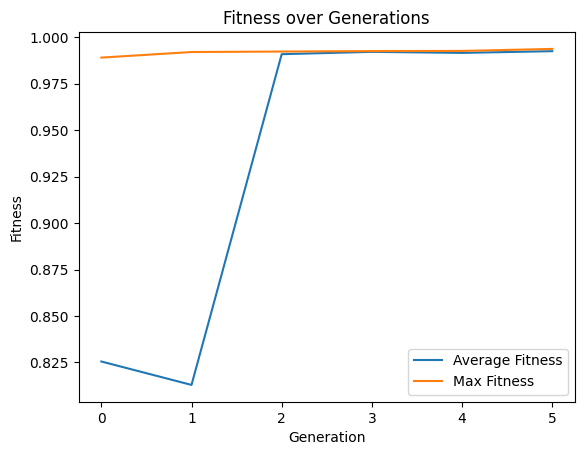

In [35]:
gen = log.select("gen")
fit_avg = log.select("avg")
fit_max = log.select("max")

plt.plot(gen, fit_avg, label="Average Fitness")
plt.plot(gen, fit_max, label="Max Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations")
plt.legend()
plt.show()

In [42]:
batch_size = best_individual["batch_size"]
optimizer = best_individual["optimizer"]
lr = best_individual["lr"]
weight_decay = best_individual["weight_decay"]
momentum = best_individual.get("momentum", None)

train_loader, val_loader, test_loader = build_dataloaders(trainset, testset, batch_size, config.SEED)

model = CNN().to(config.DEVICE)

criterion = nn.CrossEntropyLoss()
if optimizer in (optim.RMSprop, optim.SGD):
        optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
if optimizer == optim.Adam:
        optimizer = optimizer(model.parameters(), lr=lr, weight_decay=weight_decay)

In [45]:
best_val_acc = 0.0
patience = 5
patience_counter = 0
history = {"val_loss": [], "val_acc": []}
for epoch in range(config.EPOCHS):
    model.train()
    for x, y in train_loader:
        x, y = x.to(config.DEVICE), y.to(config.DEVICE)
        logits = model(x)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    val_loss, val_acc = evaluate(model, val_loader, criterion)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{config.EPOCHS} - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            break

Epoch 1/10 - Val Loss: 0.0388, Val Acc: 0.9888
Epoch 2/10 - Val Loss: 0.0395, Val Acc: 0.9886
Epoch 3/10 - Val Loss: 0.0344, Val Acc: 0.9908
Epoch 4/10 - Val Loss: 0.0415, Val Acc: 0.9884
Epoch 5/10 - Val Loss: 0.0367, Val Acc: 0.9904
Epoch 6/10 - Val Loss: 0.0386, Val Acc: 0.9905
Epoch 7/10 - Val Loss: 0.0457, Val Acc: 0.9883
Epoch 8/10 - Val Loss: 0.0372, Val Acc: 0.9908
